In [1]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2



In [2]:
img_og_1 = cv2.cvtColor(cv2.imread("/content/foto5A.jpeg"), cv2.COLOR_BGR2RGB)
img_gray_1 = cv2.cvtColor(img_og_1, cv2.COLOR_RGB2GRAY)
img_og_2 = cv2.cvtColor(cv2.imread("/content/foto5B.jpeg"), cv2.COLOR_BGR2RGB)
img_gray_2 = cv2.cvtColor(img_og_2, cv2.COLOR_RGB2GRAY)

print (cv2 .__version__)

4.4.0


In [2]:
#!pip install opencv-contrib-python==4.4.0.44

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55.7 MB 1.1 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
#Step-1+2 ---
#Using the SIFT_create method of cv2, a sift variable is created to detect the local features of image
#using detectAndCompute from sift to return a tuple containing the keypoints and the descriptors of image(gray-scaled image)

In [4]:
def sifter(img_gray):
  sift = cv2.SIFT_create()
  temp=sift.detectAndCompute(img_gray, None)
  return temp

temp_1 = sifter(img_gray_1)
temp_2 = sifter(img_gray_2)

In [5]:
#Step-3 ---
#Displaying the keypoints on the image itself using cv2.drawKeyPoints in red colour
#Here temp[0] indicates the zero-index of the sift.detectandCompute tuple which contains the key-points

In [6]:
def show_keypoints(img_og,temp):
  keypoint = cv2.drawKeypoints(img_og,temp[0] , None, color=(255,0,0))
  plt.figure(figsize=(10,10))
  plt.imshow(keypoint)
  plt.title("_KEYPOINTS_")
  plt.show()


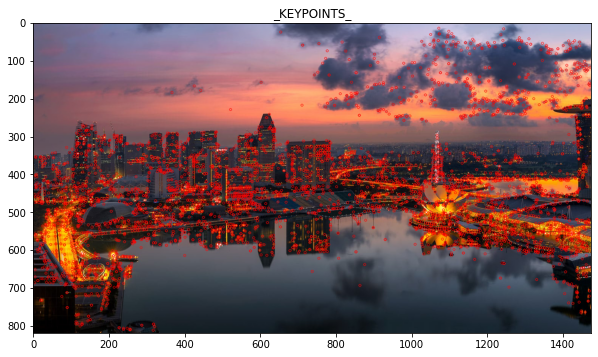

In [7]:
show_keypoints(img_og_1,temp_1)

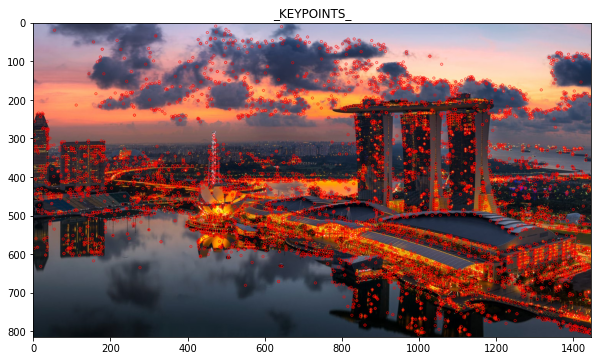

In [8]:
show_keypoints(img_og_2,temp_2)

In [9]:
#Step-4 ---
#The method being used to correlated the similar keypoints in two half images is K- Nearest Neighbour
#The cv2.BFMatcher() takes the keypoints from image_half1 and matches to all keypoints in image_half2 with the closest one being joint
#The approach of KNN is taken so that for each keypoint, k correlations are made from each keypoint to keypoints in the other half
#K-nearest Neighbour approach uses a distance ratio,whose condition needs to be satisfied to be valid as K-nearest Neighbour
#The points are matched and displayed on the plot

In [11]:
def matching_initial(img_og_1,img_og_2,temp_1,temp_2):
  value = cv2.BFMatcher()
  knn_value = value.match(temp_1[1],temp_2[1]) 
  im_matches = cv2.drawMatches(img_og_1, temp_1[0], img_og_2, temp_2[0],knn_value[0:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  plt.figure(figsize=(20, 20))
  plt.imshow(im_matches)
  plt.title("matching the keypoints")

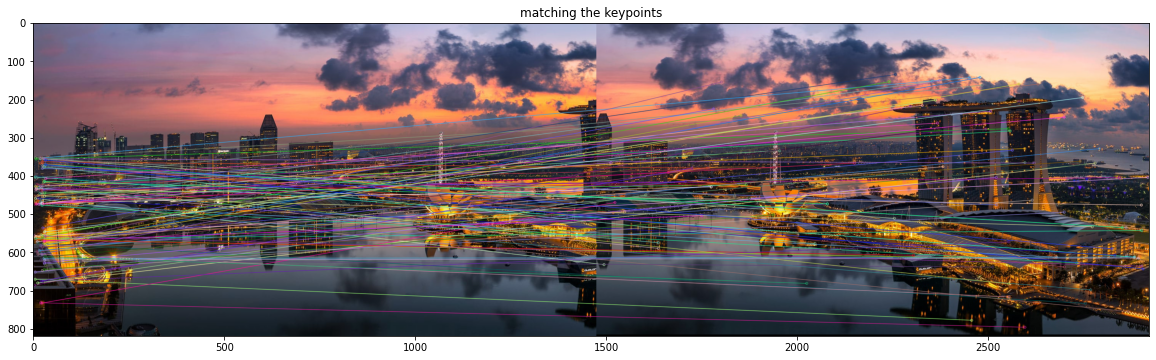

In [12]:
matching_initial(img_og_1,img_og_2,temp_1,temp_2)

In [13]:
#Step-5 ---
#Creating the Homography Matrix:
#An array is made from the best Knn points list(apt_knn_value)
#From the array, the best keypoints are chosen in the 2 images for warping, and stored in two arrays
#After the two arrays are formed, RANSAC Algo is implemented which is used in finding the homography matrix
#The Homography matrix is calculated to correlate same points from image 1 to image 2

In [16]:
def Homography(temp_1,temp_2):
  value = cv2.BFMatcher()
  knn_value = value.match(temp_1[1],temp_2[1])
  array = np.asarray(knn_value)[:] 
  apt_kp_1 = np.array([temp_1[0][p.queryIdx].pt for p in array])
  apt_kp_2 = np.array([temp_2[0][p.trainIdx].pt for p in array])
  H1, mask = cv2.findHomography(apt_kp_2,apt_kp_1, cv2.RANSAC, 2.0)
  return(H1)
H=Homography(temp_1,temp_2)
print(H)

[[ 9.99973033e-01 -2.87005697e-04  5.99085028e+02]
 [ 2.65765977e-05  9.99891617e-01  3.00587611e+00]
 [ 6.37775209e-08 -2.02601279e-07  1.00000000e+00]]


In [17]:
#Step-6 ---
#Two arrays are created having the dimensions of the original images
#The matrix of the second half is subjected to perspective transform using the Homography matrix
#The two image arrays are concatenated(added side by side)
#From the concatenated array, the maximum and minimum x-coordinate & maximum and minimum y-coordinate are extracted
#The images are warped together to fit the size of the concatenated array , and the second image and W*H are warped
#The result is adjusted to fit the dimensions of the img_og_1 and returned to the function

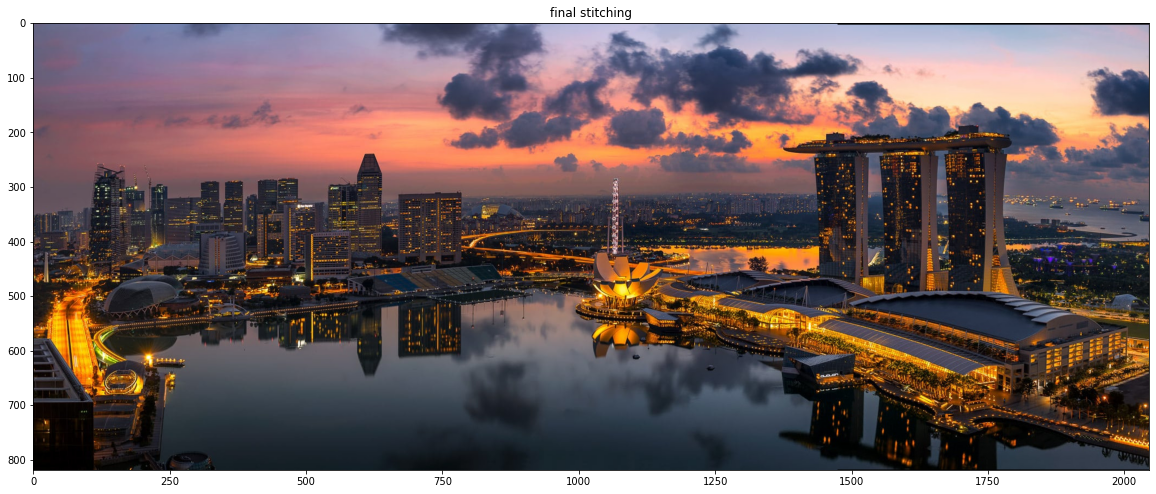

In [18]:
def stitching(img_og_1, img_og_2, H):
    height_1, width_1 = img_og_1.shape[:2]
    height_2, width_2 = img_og_2.shape[:2]
    
    point_og_1 = np.float32([[0, 0], [0, height_1], [width_1, height_1], [width_1, 0]]).reshape(-1, 1, 2)
    point_og_2 = np.float32([[0, 0], [0, height_2], [width_2, height_2], [width_2, 0]]).reshape(-1, 1, 2)
    
    pts2 = cv2.perspectiveTransform(point_og_2, H)
    pts = np.concatenate((point_og_1, pts2), axis=0)
    min_coord= np.int32(pts.min(axis=0).ravel() - 0.5)
    max_coord= np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-min_coord[0], -min_coord[1]]
    W = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]]) 

    result = cv2.warpPerspective(img_og_2, W@H, (max_coord[0]-min_coord[0], max_coord[1]-min_coord[1]))
    result[t[1]:height_1+t[1], t[0]:width_1+t[0]] = img_og_1
    return result


ultimate= stitching(img_og_1,img_og_2 ,H)

plt.figure(figsize=(20,10))
plt.imshow(ultimate)
plt.title("final stitching")
plt.show()



In [ ]:
#Saving Image

In [ ]:
import matplotlib

In [ ]:
matplotlib.image.imsave('foto5_stitched.png', ultimate)